In [1]:
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [2]:
np.random.seed(7)

ub, lb = 5, -5
d = 2
n = 4

centroids = np.random.uniform(lb, ub, (n, d))
svm = SVC(kernel='linear').fit(centroids, range(len(centroids)))

point = np.random.uniform(lb, ub, (d,))

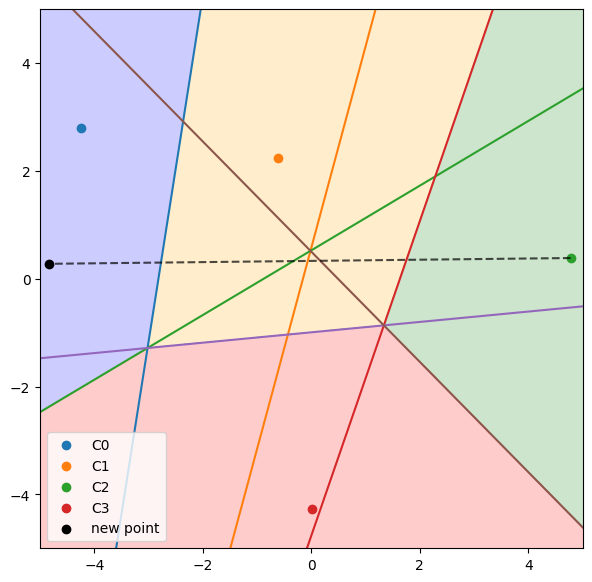

In [3]:
xx, yy = np.meshgrid(np.arange(lb, ub, .01), np.arange(lb, ub, .01))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
colors = ['blue', 'orange', 'green', 'red']
ax.contourf(xx, yy, Z, levels=[-1,0,1,2,3], colors=colors, alpha=.2)
for i, c in enumerate(centroids):
    ax.scatter(c[0], c[1],label=f"C{i}")
for coef, intercept, i in zip(svm.coef_, svm.intercept_, range(len(svm.intercept_))):
    a = -coef[0] / coef[1]
    x = np.linspace(-6,6)
    y = a*x - intercept / coef[1]
    ax.plot(x, y)
ax.plot([centroids[2][0], point[0]], [centroids[2][1], point[1]], color='black', linestyle='dashed', alpha=.7)
ax.scatter(point[0], point[1], color='black', label="new point")
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.legend()
plt.show()

In [4]:
def extract_svm_coefs(svm: SVC, targets: list[str], target: str):
    if svm:
        return [(svm.coef_[i], svm.intercept_[i]) for i, c in enumerate(combinations(targets, 2)) if target in c]
    else:
        return None

In [5]:
def closest_intersect(centroid: np.ndarray, point: np.ndarray, intersections: list[np.ndarray]):
    valids = []
    for i, intersection in enumerate(intersections):
        if abs(np.linalg.norm(centroid - point) - (np.linalg.norm(centroid - intersection) + np.linalg.norm(intersection - point))) < 1e-10:
            valids.append(i)
    if len(valids) == 0: return 0
    distances = [np.linalg.norm(intersections[i] - centroid) for i in valids]
    smallest_distance = valids[np.argmin(distances)]
    return smallest_distance

def ortho_projection(centroid: np.ndarray, coefs, point: np.ndarray, bool):
        intersections = []
        for coef_, intercept_ in coefs:
            f = np.append(coef_, 0)
            # solve for vector intercept
            A = [f]
            B = [-intercept_]
            t = centroid - point
            # print(f"t: {t}")
            for i in range(len(t)):
                x = np.zeros((len(t)+1,))
                x[i] = 1
                x[-1] = t[i]
                A.append(x)
                B.append(point[i])
            # print(A,B)
            intersection = np.linalg.solve(A, B)[:-1]
            intersections.append(intersection)
        j = closest_intersect(centroid, point, intersections)
        if j is None:
            return centroid
        if bool:
            return intersections[j]
        plane = coefs[j][0]
        vector = point - intersections[j]
        # projection
        pj = -np.dot(plane, vector) / np.dot(plane, plane)
        pj_point = plane*pj + point
        return pj_point

In [6]:
target = 2
coefs = extract_svm_coefs(svm, range(n), target)
target_centroid = centroids[target]
intersections = ortho_projection(target_centroid, coefs, point, True)
pj = ortho_projection(target_centroid, coefs, point, False)
print(f"Intersections with hyperplanes: {intersections}")
print(f"Projection of closest intersect: {pj}")

Intersections with hyperplanes: [1.753382   0.35120084]
Projection of closest intersect: [ 1.03739071 -1.7374418 ]


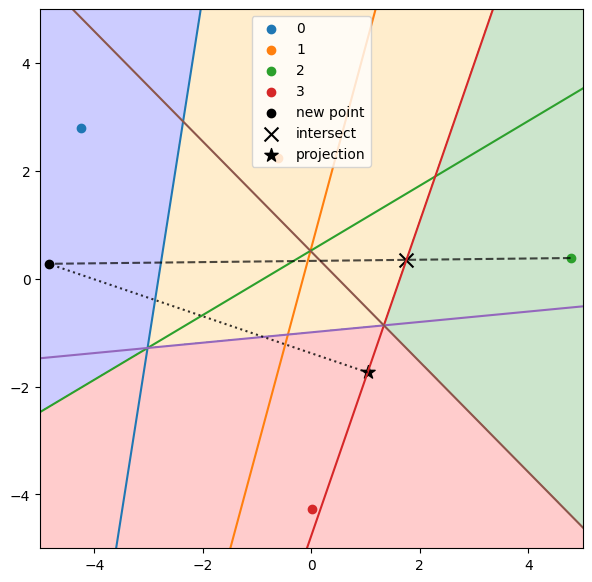

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
colors = ['blue', 'orange', 'green', 'red']
ax.contourf(xx, yy, Z, levels=[-1,0,1,2,3], colors=colors, alpha=.2)
for i, c in enumerate(centroids):
    ax.scatter(c[0], c[1], label=i)
for coef, intercept, i in zip(svm.coef_, svm.intercept_, range(len(svm.intercept_))):
    a = -coef[0] / coef[1]
    x = np.linspace(-6,6)
    y = a*x - intercept / coef[1]
    ax.plot(x, y)
ax.scatter(point[0], point[1], color='black', label="new point")
ax.plot([centroids[2][0], point[0]], [centroids[2][1], point[1]], color='black', linestyle='dashed', alpha=.7)
ax.scatter(intersections[0], intersections[1], label="intersect", marker='x', color='black', s=100)
ax.scatter(pj[0], pj[1], label="projection", marker='*', color='black', s=100)
ax.plot([pj[0], point[0]], [pj[1], point[1]], linestyle='dotted', color='black', alpha=.8)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.legend()
plt.show()